In [119]:
from typing import Callable

import numpy as np
import pandas as pd
import scipy.constants as consts
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import patheffects

%matplotlib widget

In [120]:
# Define constants
RHO = 1.225  # kg / m^3

# Define requirements
v_cruise = 30. * consts.knot
v_stall = 8. * consts.knot
r_turn = 200 * consts.foot
climb_rate = 400 * consts.foot / consts.minute
altitude = 200 * consts.foot

lap_straight = 600 * consts.foot
num_laps = 3
max_GLOM = 20 * consts.lb
max_wingspan = 5 * consts.foot

# Define assumptions
v_turn = v_cruise
v_climb = 0.8 * v_cruise

CLIMB_L_D_SCALE = 0.866
TURN_L_D_SCALE = 0.95

# Conservative
CL_max_conserv = 1.2
CD_0_conserv = 0.05
eta_prop_conserv = 0.6
L_D_max_conserv = 10
AR_conserv = 5
e_oswald_conserv = 0.70
k_conserv = 1 / (np.pi * AR_conserv * e_oswald_conserv)
eta_motor_conserv = 0.7
enrg_density_conserv = 150 * consts.hour

# Aggressive
CL_max_aggr = 1.8
CD_0_aggr = 0.025
eta_prop_aggr = 0.85
L_D_max_aggr = 15
AR_aggr = 8
e_oswald_aggr = 0.85
k_aggr = 1 / (np.pi * AR_aggr * e_oswald_aggr)
eta_motor_aggr = 0.9
enrg_density_aggr = 250 * consts.hour

# Derived values
climb_angle = np.asin(climb_rate / v_cruise)
load_factor = np.sqrt((v_turn**2 / r_turn / consts.g)**2 + 1)
bank_angle = np.acos(1 / load_factor)

print(f"Climb angle      = {np.rad2deg(climb_angle):.2f}°")
print(f"Turn load factor = {load_factor:.3f}")
print(f"Turn bank angle  = {np.rad2deg(bank_angle):.1f}°")

Climb angle      = 7.57°
Turn load factor = 1.076
Turn bank angle  = 21.7°


In [121]:
def mk_stall_cond_func(
    CL_max: float, vs: float, rho: float = RHO
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make stall condition constraint function.

    :param float CL_max: Maximum lift coefficient
    :param float vs: Stall true airspeed
    :param float rho: (optional) Atmospheric density
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (CL_max * rho * vs**2 * 0.5) - ws

    return f

In [122]:
def mk_cruise_cond_func(
    vc: float, CD_0: float, eta_p: float, rho: float = RHO, CD_scale: float = 1.1
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vc: Cruise true airspeed
    :param float CD_0: Zero-lift form drag
    :param float eta_p: Propeller efficiency
    :param float rho: (optional) Atmospheric density
    :param float CD_scale: (optional) Scale factor for total drag (including induced drag)
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (eta_p * 2.) / (rho * vc**3 * CD_scale * CD_0) * ws - wp

    return f

In [123]:
def mk_climb_cond_func(
    vcl: float, gamma: float, eta_p: float, L_D_max: float, L_D_scale: float = CLIMB_L_D_SCALE
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vcl: Climb true airspeed
    :param float gamma: Climb rate
    :param float eta_p: Propeller efficiency
    :param float L_D_max: Maximum lift-to-drag ratio L/D
    :param float L_D_scale: (optional) Scale factor for L/D ration during climb
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return eta_p / vcl / (gamma + 1 / (L_D_max * L_D_scale)) - wp

    return f

In [124]:
def mk_turn_cond_func(
    vtr: float, CD_0: float, eta_p: float, n: float, k: float, rho: float = RHO,
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vtr: Turn true airspeed
    :param float CD_0: Zero-lift form drag
    :param float eta_p: Propeller efficiency
    :param float n: Turn load factor
    :param float k: Induced drag factor 1 / π AR e
    :param float rho: (optional) Atmospheric density
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """
    
    q = 0.5 * rho * vtr**2

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (eta_p / q / vtr / (k * (n / q)**2 * ws + CD_0 / ws)) - wp

    return f

In [125]:
# Conservative constraints
stall_f_conserv = mk_stall_cond_func(CL_max_conserv, v_stall)
cruise_f_conserv = mk_cruise_cond_func(v_cruise, CD_0_conserv, eta_prop_conserv)
climb_f_conserv = mk_climb_cond_func(v_climb, climb_angle, eta_prop_conserv, L_D_max_conserv)
turn_f_conserv = mk_turn_cond_func(v_turn, CD_0_conserv, eta_prop_conserv, load_factor, k_conserv)

# Agressive constraints
stall_f_aggr = mk_stall_cond_func(CL_max_aggr, v_stall)
cruise_f_aggr = mk_cruise_cond_func(v_cruise, CD_0_aggr, eta_prop_aggr)
climb_f_aggr = mk_climb_cond_func(v_climb, climb_angle, eta_prop_aggr, L_D_max_aggr)
turn_f_aggr = mk_turn_cond_func(v_turn, CD_0_aggr, eta_prop_aggr, load_factor, k_aggr)

In [126]:
# Constraint domain
min_wing_loading = 2.9 * consts.g  # Ozone Buzz Z3 MS (paraglider)
max_wing_loading = 837 * consts.g  # McDonnel Douglas MD-11 (widebody airliner)
min_power_loading = 1 / (634 / consts.g)  # Supermarine S.6B (racing aircraft)
max_power_loading = 1 / (106 / consts.g)  # Boeing B-29 (heavy bomber)

ws_lo = np.floor(np.log10(min_wing_loading))
ws_hi = np.floor(np.log10(max_wing_loading))
wp_lo = np.floor(np.log10(min_power_loading)) - 1
wp_hi = np.ceil(np.log10(max_power_loading)) + 1

ws = np.logspace(ws_lo, ws_hi)  # Wing loading N/m^2
wp = np.logspace(wp_lo, wp_hi)  # Power loading N/W

ws, wp = np.meshgrid(ws, wp)

In [127]:
# Wing and power loading cost function for optimization
def cost_fn(x: np.ndarray):
    ws, wp = x
    
    return -ws - wp

# Constraint functions converted for optimization
constrs = (
    {'type': 'ineq', 'fun': lambda x: stall_f_conserv(*x)},
    {'type': 'ineq', 'fun': lambda x: cruise_f_conserv(*x)},
    {'type': 'ineq', 'fun': lambda x: climb_f_conserv(*x)},
    {'type': 'ineq', 'fun': lambda x: turn_f_conserv(*x)},
)

# Bounds on solver space
bnds = ((10**ws_lo, 10**ws_hi), (10**wp_lo, 10**wp_hi))

optim_res = minimize(cost_fn, (10**ws_lo, 10**wp_lo), bounds=bnds, constraints=constrs)

ws_optim, wp_optim = optim_res.x

optim_res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -12.509599269276896
       x: [ 1.245e+01  6.032e-02]
     nit: 3
     jac: [-1.000e+00 -1.000e+00]
    nfev: 9
    njev: 3

In [128]:
stall_conserv = stall_f_conserv(ws, wp)
cruise_conserv = cruise_f_conserv(ws, wp)
climb_conserv = climb_f_conserv(ws, wp)
turn_conserv = turn_f_conserv(ws, wp)

stall_aggr = stall_f_aggr(ws, wp)
cruise_aggr = cruise_f_aggr(ws, wp)
climb_aggr = climb_f_aggr(ws, wp)
turn_aggr = turn_f_aggr(ws, wp)

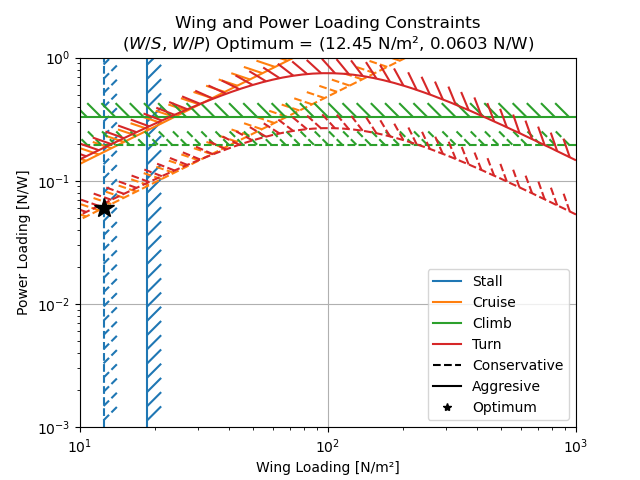

In [129]:
fig, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.set_yscale('log')

stall_cntr_conserv = ax.contour(ws, wp, stall_conserv, [0], colors="C0", linestyles="--")
stall_cntr_conserv.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
stall_cntr_aggr = ax.contour(ws, wp, stall_aggr, [0], colors="C0", linestyles="-")
stall_cntr_aggr.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

cruise_cntr_conserv = ax.contour(ws, wp, cruise_conserv, [0], colors="C1", linestyles="--")
cruise_cntr_conserv.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
cruise_cntr_aggr = ax.contour(ws, wp, cruise_aggr, [0], colors="C1", linestyles="-")
cruise_cntr_aggr.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

climb_cntr_conserv = ax.contour(ws, wp, climb_conserv, [0], colors="C2", linestyles="--")
climb_cntr_conserv.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
climb_cntr_aggr = ax.contour(ws, wp, climb_aggr, [0], colors="C2", linestyles="-")
climb_cntr_aggr.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

turn_cntr_conserv = ax.contour(ws, wp, turn_conserv, [0], colors="C3", linestyles="--")
turn_cntr_conserv.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
turn_cntr_aggr = ax.contour(ws, wp, turn_aggr, [0], colors="C3", linestyles="-")
turn_cntr_aggr.set(path_effects=[patheffects.withTickedStroke(angle=-45)])


ax.plot(ws_optim, wp_optim, '*k', markersize=15)

ax.set_xlabel("Wing Loading [N/m²]")
ax.set_ylabel("Power Loading [N/W]")
legend_lines = [
    plt.Line2D([], [], color='C0', label="Stall"),
    plt.Line2D([], [], color='C1', label="Cruise"),
    plt.Line2D([], [], color='C2', label="Climb"),
    plt.Line2D([], [], color='C3', label="Turn"),
    plt.Line2D([], [], color='k', linestyle='--', label="Conservative"),
    plt.Line2D([], [], color='k', label="Aggresive"),
    plt.Line2D([], [], color='k', linestyle='', marker='*', label="Optimum"),
]
ax.legend(handles=legend_lines, loc="lower right")
ax.set_title(f"Wing and Power Loading Constraints\n($W/S$, $W/P$) Optimum = ({ws_optim:.2f} N/m², {wp_optim:.4f} N/W)")
ax.grid()

array([0.19717912, 0.13343333])

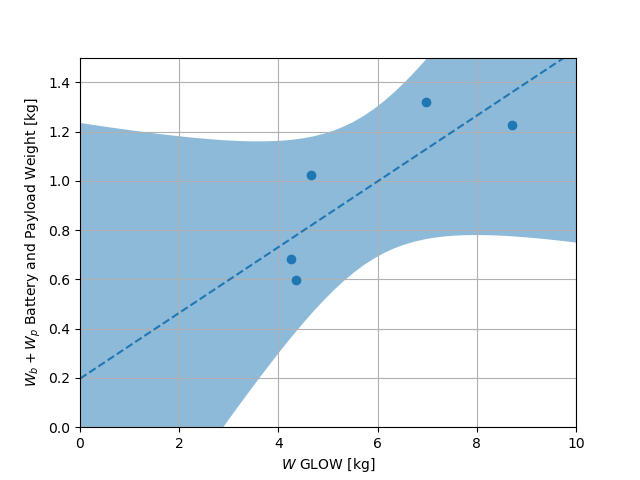

In [130]:
# Class historical W, Wp_Wb data (digitized from plot)
m_data = np.array([9.57912457912458, 9.393939393939394, 10.286195286195285, 15.387205387205388, 19.19191919191919]) * consts.lb
mp_mb_data= np.array([1.3171378091872792, 1.5026501766784452, 2.2570671378091873, 2.9125441696113072, 2.7022968197879855]) * consts.lb

X = sm.add_constant(m_data)
ols_model = sm.OLS(mp_mb_data, X)
est = ols_model.fit()

m_range = np.linspace(0, 10)
X2 = sm.add_constant(m_range)
pred = est.get_prediction(X2).summary_frame()

fig, ax = plt.subplots(1,1)
ax.plot(m_data, mp_mb_data, 'o')
ax.fill_between(m_range, pred['mean_ci_lower'], pred['mean_ci_upper'], alpha=0.5)
ax.plot(m_range, pred['mean'], "C0--")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1.5)
ax.set_xlabel("$W$ GLOW [kg]")
ax.set_ylabel("$W_b + W_p$ Battery and Payload Weight [kg]")
ax.grid()

est.params

In [131]:
def predict_specific_energy_level_flight(dist: float, L_D_cruise: float) -> float:
    """
    Predict the specific energy consumed during level flight

    :param float dist: Level flight distance range
    :param float L_D_cruise: L/D lift to drag ratio in level flight
    :return float: Specific energy consumption E/m
    """

    return dist * consts.g / L_D_cruise

In [132]:
def predict_specific_energy_turn_flight(
    dist: float, L_D_turn: float, load_factor: float
) -> float:
    """
    Predict the specific energy consumed during turning flight

    :param float dist: Turning flight distance range
    :param float L_D_turn: L/D lift to drag ratio in level flight
    :param float load_factor: Turn load factor
    :return float: Specific energy consumption E/m
    """

    return dist * consts.g * load_factor / L_D_turn

In [133]:
def predict_specific_energy_climb(
    altitude: float, L_D_climb: float, climb_angle: float
) -> float:
    """
    Predict the specific energy consumed during climb phase

    :param float altitude: Total altitude of climb
    :param float L_D_climb: L/D lift to drag ratio in level flight
    :param float climb_angle: Angle of climb
    :return float: Specific energy consumption E/m
    """

    return altitude * consts.g * (1 + 1 / (np.tan(climb_angle) * L_D_climb))

In [134]:
def predict_specific_energy_total(
    dist_straight: float,
    turn_radius: float,
    climb_alt: float,
    L_D_max: float,
    load_factor: float,
    climb_angle: float,
    num_laps: int = 1,
    L_D_factor_turn: float = TURN_L_D_SCALE,
    L_D_factor_climb: float = CLIMB_L_D_SCALE,
):
    """
    Predict the specific energy consumed during a mission and report a the
    the breakdowns. Assumes an oval racetrack path with a straightaway distance
    of `dist_straight` and semicircular caps with radius `turn_radius`, for a
    total oval length of `2 * dist_straight + 2*pi * turn_radius`. This is
    repeated `num_laps` times. A climb at `climb_angle` to an altitude of
    `climb_alt` preceedes the laps.

    :param float dist_straight: Straightaway distance of one half lap
    :param float turn_radius: Turn radius of lap
    :param float climb_alt: Altitude to climb to
    :param float L_D_max: Maximum lift-to-drag ratio L/D of aircraft
    :param float load_factor: Turn load factor
    :param float climb_angle: Climb rate angle
    :param float num_laps: (optional) Number of laps in mission
    :param float L_D_factor_turn: (optional) Scale factor for L/D ration during turn
    :param float L_D_factor_climb: (optional) Scale factor for L/D ration during climb
    """

    lap_straight = 2 * dist_straight
    lap_turn = 2 * np.pi * turn_radius
    lap_total = lap_straight + lap_turn

    total_straight = lap_straight * num_laps
    total_turn = lap_turn * num_laps
    total_range = total_straight + total_turn

    L_D_straight = L_D_max
    L_D_turn = L_D_max * L_D_factor_turn
    L_D_climb = L_D_max * L_D_factor_climb

    e_straight_lap = predict_specific_energy_level_flight(lap_straight, L_D_straight)
    e_turn_lap = predict_specific_energy_turn_flight(lap_turn, L_D_turn, load_factor)
    e_lap = e_straight_lap + e_turn_lap
    
    e_straight_total = predict_specific_energy_level_flight(total_straight, L_D_straight)
    e_turn_total = predict_specific_energy_turn_flight(total_turn, L_D_turn, load_factor)
    e_total_laps = e_straight_total + e_turn_total
    
    e_climb = predict_specific_energy_climb(climb_alt, L_D_climb, climb_angle)
    
    e_total = e_climb + e_total_laps

    return e_total, {
        "e_total": e_total,
        "e_climb": e_climb,
        "e_total_laps": e_total_laps,
        "e_straight_total": e_straight_total,
        "e_turn_total": e_turn_total,
        "e_lap": e_lap,
        "e_straight_lap": e_straight_lap,
        "e_turn_lap": e_turn_lap,
        "range_total": total_range,
        "range_straight": total_straight,
        "range_turn": total_turn,
        "range_lap": lap_total,
        "range_lap_straight": lap_straight,
        "range_lap_turn": lap_turn,
        "climb_alt": climb_alt,
        "L_D_straight": L_D_straight,
        "L_D_turn": L_D_turn,
        "L_D_climb": L_D_climb,
    }

In [135]:
e_total_conserv, data_conserv = predict_specific_energy_total(
    lap_straight, r_turn, altitude, L_D_max_conserv, load_factor, climb_angle, num_laps
)
e_total_aggr, data_aggr = predict_specific_energy_total(
    lap_straight, r_turn, altitude, L_D_max_aggr, load_factor, climb_angle, num_laps
)

pd.DataFrame([data_conserv, data_aggr], index=["Conservative", "Aggressive"])

,e_total,e_climb,e_total_laps,e_straight_total,e_turn_total,e_lap,e_straight_lap,e_turn_lap,range_total,range_straight,range_turn,range_lap,range_lap_straight,range_lap_turn,climb_alt,L_D_straight,L_D_turn,L_D_climb
Conservative,3470.461207,1117.553791,2352.907416,1076.064091,1276.843325,784.302472,358.688030,425.614442,2246.348929,1097.28,1149.068929,748.782976,365.76,383.022976,60.96,10,9.50,8.66
Aggressive,2512.911933,944.306989,1568.604944,717.376061,851.228883,522.868315,239.125354,283.742961,2246.348929,1097.28,1149.068929,748.782976,365.76,383.022976,60.96,15,14.25,12.99


In [136]:
def estimate_battery_mass_fraction_props(
    e_total: float,
    eta_prop: float,
    eta_motor: float,
    battery_e_density: float,
    margin: float,
):
    """
    Estimate the battery mass fraction from other parameters.

    :param float e_total: Mission specific energy total
    :param float eta_prop: Propeller efficiency
    :param float eta_motor: Motor efficiency
    :param float battery_e_density: Battery energy density
    :param float margin: Energy margin
    """

    e_batt = e_total * margin / (eta_prop * eta_motor)
    mb_m = e_batt / battery_e_density

    return mb_m, {
        "mb/m": mb_m,
        "mission specific energy": e_total,
        "specific energy with margin": e_total * margin,
        "battery specific energy": e_batt,
    }

In [137]:
mb_m_conserv, bat_props_conserv = estimate_battery_mass_fraction_props(e_total_conserv, eta_prop_conserv, eta_motor_conserv, enrg_density_conserv, 2.5)
mb_m_aggr, bat_props_aggr= estimate_battery_mass_fraction_props(e_total_aggr, eta_prop_aggr, eta_motor_aggr, enrg_density_aggr, 2.5)

pd.DataFrame([bat_props_conserv, bat_props_aggr], index=["Conservative", "Agressive"])

,mb/m,mission specific energy,specific energy with margin,battery specific energy
Conservative,0.038255,3470.461207,8676.153018,20657.507187
Agressive,0.009125,2512.911933,6282.279832,8212.130500


In [138]:
X3 = sm.add_constant([0, max_GLOM, 10])
mp_mb_pred = est.get_prediction(X3).summary_frame()

mp_mb_mean = mp_mb_pred.loc[1, "mean"]
mp_mb_pred.loc[1]

mean             1.407666
mean_se          0.200636
mean_ci_lower    0.769152
mean_ci_upper    2.046180
obs_ci_lower     0.477104
obs_ci_upper     2.338228
Name: 1, dtype: float64

In [139]:
mb_conserv = mb_m_conserv * max_GLOM
mb_aggr = mb_m_aggr * max_GLOM

mp_conserv = mp_mb_mean - mb_conserv

mb_conserv, mp_conserv

(np.float64(0.34704028307906143), np.float64(1.0606256779524497))

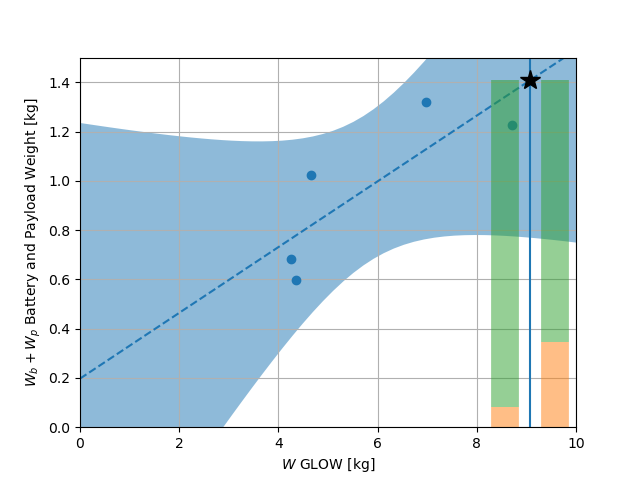

In [140]:
fig, ax = plt.subplots(1,1)
ax.plot(m_data, mp_mb_data, 'o')
ax.fill_between(m_range, pred['mean_ci_lower'], pred['mean_ci_upper'], alpha=0.5)
ax.plot(m_range, pred['mean'], "C0--")

ax.axvline(max_GLOM)
ax.plot(max_GLOM, mp_mb_mean, "k*", markersize=15)
ax.vlines(max_GLOM + 0.5, 0, mb_conserv, linewidths=20, colors="C1", alpha=0.5)
ax.vlines(max_GLOM - 0.5, 0, mb_aggr, linewidths=20, colors="C1", alpha=0.5)
ax.vlines(max_GLOM + 0.5, mb_conserv, mp_mb_mean, linewidths=20, colors="C2", alpha=0.5)
ax.vlines(max_GLOM - 0.5, mb_aggr, mp_mb_mean, linewidths=20, colors="C2", alpha=0.5)

ax.set_xlim(0, 10)
ax.set_ylim(0, 1.5)
# ax.set_aspect("equal")
ax.set_xlabel("$W$ GLOW [kg]")
ax.set_ylabel("$W_b + W_p$ Battery and Payload Weight [kg]")
ax.grid()

In [141]:
batt_energy_conserv = bat_props_conserv["battery specific energy"] * max_GLOM
batt_energy_aggr = bat_props_aggr["battery specific energy"] * max_GLOM

batt_energy_conserv, batt_energy_aggr

(np.float64(187401.75286269316), np.float64(74499.19472242973))

In [142]:
batt_Wh_conserv = batt_energy_conserv / consts.hour
batt_Wh_aggr = batt_energy_aggr / consts.hour

batt_Wh_conserv, batt_Wh_aggr

(np.float64(52.056042461859214), np.float64(20.694220756230482))

In [143]:
num_cells = 6
volts = num_cells * 3.7

batt_mAh_conserv = batt_Wh_conserv / volts * 1000
batt_mAh_aggr = batt_Wh_aggr / volts * 1000

batt_mAh_conserv, batt_mAh_aggr

(np.float64(2344.8667775612257), np.float64(932.1721061365081))

In [144]:
GLOW = max_GLOM * consts.g

wing_area = GLOW / ws_optim
power = GLOW / wp_optim

wing_area, power

(np.float64(7.146150125605554), np.float64(1474.9213879198546))

In [145]:
wing_chord = wing_area / max_wingspan

wing_chord

np.float64(4.689074885567949)

In [146]:
batt_power_conserv = power / eta_prop_conserv / eta_motor_conserv
batt_power_aggr = power / eta_prop_aggr / eta_motor_aggr

batt_power_conserv, batt_power_aggr

(np.float64(3511.7175902853687), np.float64(1928.0018142743197))

In [147]:
batt_amps_conserv = batt_power_conserv / volts
batt_amps_aggr = batt_power_aggr / volts

batt_amps_conserv, batt_amps_aggr

(np.float64(158.18547703988145), np.float64(86.8469285709153))

In [148]:
batt_c_factor_conserv = batt_amps_conserv * 1000 / batt_mAh_conserv
batt_c_factor_aggr = batt_amps_aggr * 1000 / batt_mAh_conserv

batt_c_factor_conserv, batt_c_factor_aggr

(np.float64(67.46032591429436), np.float64(37.03704167843611))